### TP 1 : General Observation on Order Book Data

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [17]:
# Step 0 : Download of libraries
import numpy 
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
import tqdm   
# import hawkes as hwk
import sys
import os

Question 1 : General statistical analysis on the dataset

In [35]:
# step 1 : load the data
Path = sys.path[0] + "\\Data\\SG"
filename_df = pd.read_csv(Path + "\\SG_20170117.csv.gz", compression = 'gzip') 
filename_df.drop(filename_df.columns[0], axis = 1, inplace = True)

In [36]:
filename_df

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,20170117:09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,20170117:09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,20170117:09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,20170117:09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,20170117:09:01:00.360001,A,45970,22,B,46010,1066,46085,1445
...,...,...,...,...,...,...,...,...,...
841144,20170117:17:29:59.997678,A,45845,187,S,45820,377,45845,187
841145,20170117:17:29:59.997691,C,45720,1250,B,45820,377,45845,187
841146,20170117:17:29:59.997884,C,45765,110,B,45820,377,45845,187
841147,20170117:17:29:59.998327,A,45740,110,B,45820,377,45845,187


In [37]:
# Convert timestamps to datetime objects 
filename_df['ets'] = pd.to_datetime(filename_df['ets'], format="%Y%m%d:%H:%M:%S.%f")
filename_df

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445
...,...,...,...,...,...,...,...,...,...
841144,2017-01-17 17:29:59.997678,A,45845,187,S,45820,377,45845,187
841145,2017-01-17 17:29:59.997691,C,45720,1250,B,45820,377,45845,187
841146,2017-01-17 17:29:59.997884,C,45765,110,B,45820,377,45845,187
841147,2017-01-17 17:29:59.998327,A,45740,110,B,45820,377,45845,187


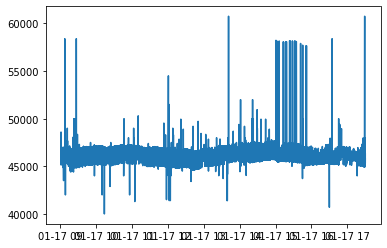

In [40]:
# We are first going to plot the price of the stock over time
plt.plot(filename_df['ets'], filename_df['eprice'])
plt.show()

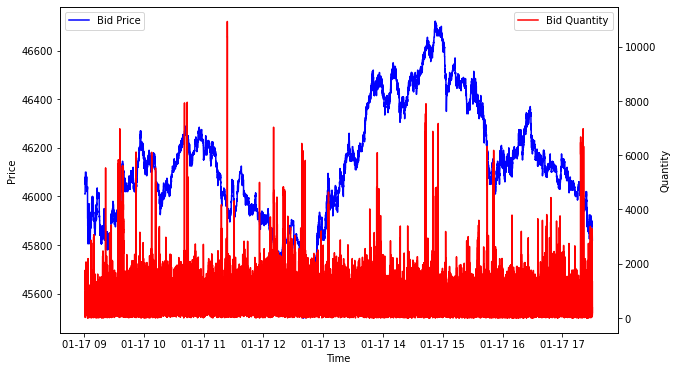

In [48]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(filename_df['ets'], filename_df['bp0'], color = "b", label="Bid Price")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax2 = ax1.twinx()
ax2.plot(filename_df['ets'], filename_df['bq0'], color = "r", label="Bid Quantity")
ax2.set_ylabel("Quantity")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

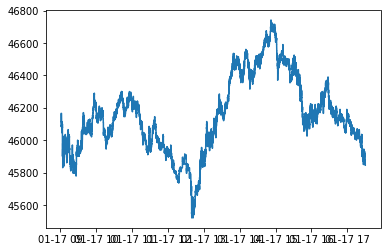

In [43]:
plt.plot(filename_df['ets'], filename_df['ap0'])
plt.show()